In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# initialize MLflow
import mlflow

# Uncomment the following line to log a a stand-alone server.
#mlflow.set_tracking_uri(uri="http://localhost:5000")

mlflow.set_experiment("Wind Chill Example")

2025/05/20 16:17:10 INFO mlflow.tracking.fluent: Experiment with name 'Wind Chill Example' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1747750630015, experiment_id='1', last_update_time=1747750630015, lifecycle_stage='active', name='Wind Chill Example', tags={}>

Epoch [500/10000], Loss: 0.7531, val_loss: 0.7348
Epoch [1000/10000], Loss: 0.5366, val_loss: 0.5701
Epoch [1500/10000], Loss: 0.4363, val_loss: 0.4550
Epoch [2000/10000], Loss: 0.3633, val_loss: 0.3525
Epoch [2500/10000], Loss: 0.3058, val_loss: 0.2755
Epoch [3000/10000], Loss: 0.2666, val_loss: 0.2279
Epoch [3500/10000], Loss: 0.2293, val_loss: 0.1882
Epoch [4000/10000], Loss: 0.0775, val_loss: 0.1131
Epoch [4500/10000], Loss: 0.0611, val_loss: 0.0835
Epoch [5000/10000], Loss: 0.0444, val_loss: 0.0574
Epoch [5500/10000], Loss: 0.0305, val_loss: 0.0373
Epoch [6000/10000], Loss: 0.0249, val_loss: 0.0290
Epoch [6500/10000], Loss: 0.0211, val_loss: 0.0241
Epoch [7000/10000], Loss: 0.0180, val_loss: 0.0224
Epoch [7500/10000], Loss: 0.0156, val_loss: 0.0197
Epoch [8000/10000], Loss: 0.0139, val_loss: 0.0176
Epoch [8500/10000], Loss: 0.0120, val_loss: 0.0162
Epoch [9000/10000], Loss: 0.0106, val_loss: 0.0146
Epoch [9500/10000], Loss: 0.0092, val_loss: 0.0127
Epoch [10000/10000], Loss: 0.007

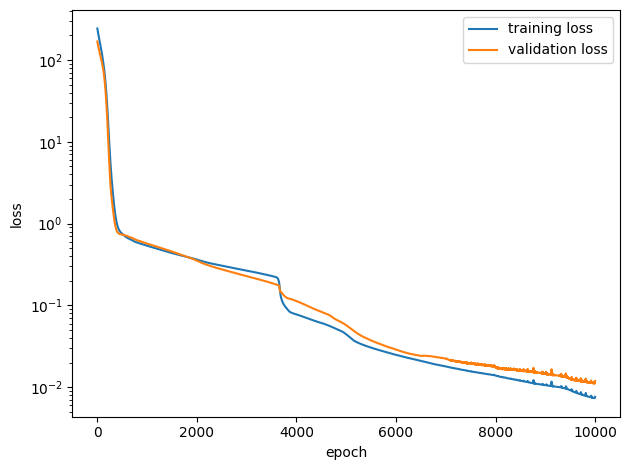

In [3]:
#######
# Generate data
n_samples = 500

tt = np.random.uniform(-20, 10, n_samples)  # Temperature in Celsius
ff = np.random.uniform(0, 50, n_samples)  # Wind speed in km/h

# Wind Chill Formula
wc = 13.12 + 0.6215 * tt - 11.37 * (ff ** 0.16) + 0.3965 * tt * (ff ** 0.16)

# Convert to PyTorch tensors
x_train = torch.tensor(np.column_stack((tt, ff)), dtype=torch.float32)
y_train = torch.tensor(wc, dtype=torch.float32).view(-1, 1)

##########
# Step 2: Build a Neural Network Model with Hidden Layers
class wind_chill_model(nn.Module):
    def __init__(self, hidden_dim):
        super(wind_chill_model, self).__init__()
        self.fc1 = nn.Linear(2, hidden_dim)  # First hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, 1)  # Output layer
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply ReLU after the first hidden layer
        x = self.relu(self.fc2(x))  # Apply ReLU after the second hidden layer
        x = self.fc3(x)  # Output layer (no activation for regression)
        return x

hidden_dim = 20
model = wind_chill_model(hidden_dim=hidden_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


#########
# Create a validation data set
n_vsamples=100

vtt = np.random.uniform(-20, 10, n_vsamples)  # Temperature in Celsius
vff = np.random.uniform(0, 50, n_vsamples)  # Wind speed in km/h
vwc = 13.12 + 0.6215 * vtt - 11.37 * (vff ** 0.16) + 0.3965 * vtt * (vff ** 0.16)

x_val = torch.tensor(np.column_stack((vtt, vff)), dtype=torch.float32)
y_val = torch.tensor(vwc, dtype=torch.float32).view(-1, 1)


##########
# Training loop
train_loss = []  # Initialize loss list
validation_loss = [] # validation loss
n_epoch = 10000  # Set number of epochs

with mlflow.start_run(run_name="logging 01"):
  # Log the hyperparameters
  mlflow.log_params({
    "hidden_dim": hidden_dim,
  })

  for epoch in range(n_epoch):
    model.train()  # Set model to train mode
    optimizer.zero_grad()  # Clear gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Compute loss
    loss.backward()  # Backpropagate error
    optimizer.step()  # Update weights

    train_loss.append(loss.item())  # Save loss

    y_pred=model(x_val) # predict on validateion dataset
    vloss=criterion(y_pred,y_val)
    validation_loss.append(vloss.item())

    # Print losses every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{n_epoch}], Loss: {loss.item():.4f}, val_loss: {vloss.item():.4f}')

        # Log the losses metrics
        mlflow.log_metric("loss", loss.item(), step=(epoch+1)*x_train.shape[0])
        mlflow.log_metric("val_loss", vloss.item(), step=(epoch+1)*x_train.shape[0])

###########
# Loss curve
  plt.plot(np.arange(n_epoch),train_loss,label="training loss")
  plt.plot(np.arange(n_epoch),validation_loss,label="validation loss")
  plt.yscale('log')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.tight_layout()
  mlflow.log_figure(plt.gcf(), "figure.png")


In [4]:
#### Log Model
from mlflow.models import infer_signature
signature = infer_signature(x_val.numpy(), model(x_val).detach().numpy())
model_info = mlflow.pytorch.log_model(model, "model", signature=signature)

In [11]:
mlflow.end_run()